In [2]:
from skimage import io,filters, morphology, measure, draw,exposure
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import trackpy as tp
import pandas as pd
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
from skimage.filters import threshold_otsu, threshold_multiotsu
import seaborn as sns
from tqdm import tqdm

In [3]:
PATH = "<PATH/TO/DIR>/WAVE/Fig2_FigS2CD_Hem1KO/"

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
def f_linear(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

In [6]:
def seg_cells(image, threshold, sigma,min_size, max_size, plot = True):
    """
    Segment out regions with a given fluorescence threshold in a cell
 
    Parameters
    ----------
    image : 2D array
        Raw tif image (single frame).
    threshold: float
        threshold used for segmentation
    sigma: float
        Standard deviation for Gaussian kernel.The larger the value, the smoothier the gaussian fitting.
    min_size: float
        minimum size of the segmented region
    max_size: float
        maximum size of the segmented region
    plot: bool
        whether or not plot the segmentation image
    
    Returns
    -------
    region_properties: list of RegionProperties
        Each item describes one labeled region with the corresponding attributes. 
    label_mask_clean:2D array 
        Segmentations based on fluorescent intensities of the image. 
        Each integer corresponds to a unique segmentation and 0 is the background.
        
    """
    smooth = filters.gaussian(image,sigma,preserve_range=True)
    cell_mask = smooth > threshold
    label_mask = measure.label(cell_mask)
    region_properties = measure.regionprops(label_mask)  
    label_mask_clean = label_mask.copy()
    for r in region_properties:
        if r.area <= min_size or r.area >= max_size:
            label_mask_clean[label_mask_clean == r.label] = 0
    if plot:
        plt.figure(figsize = (10,10))
        plt.imshow(image)
        plt.contour(label_mask_clean,colors = 'red',linewidths = 0.7)

    region_properties = measure.regionprops(label_mask_clean,intensity_image=image)
    return region_properties,label_mask_clean

# Quantification of lamellipodia

In [7]:
name = '241030_Hem1KO_Hem1-eGFP_fmlp_tirf_2-7_SIR.tif'
image = io.imread(PATH +"example_images/"+ name)

In [8]:
image.shape

(5, 1024, 1024)

In [9]:
# image = image.T

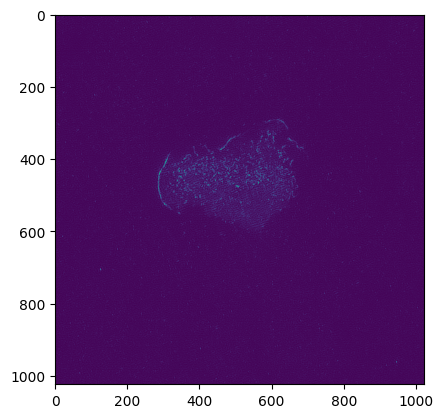

In [10]:
plt.imshow(image[0])

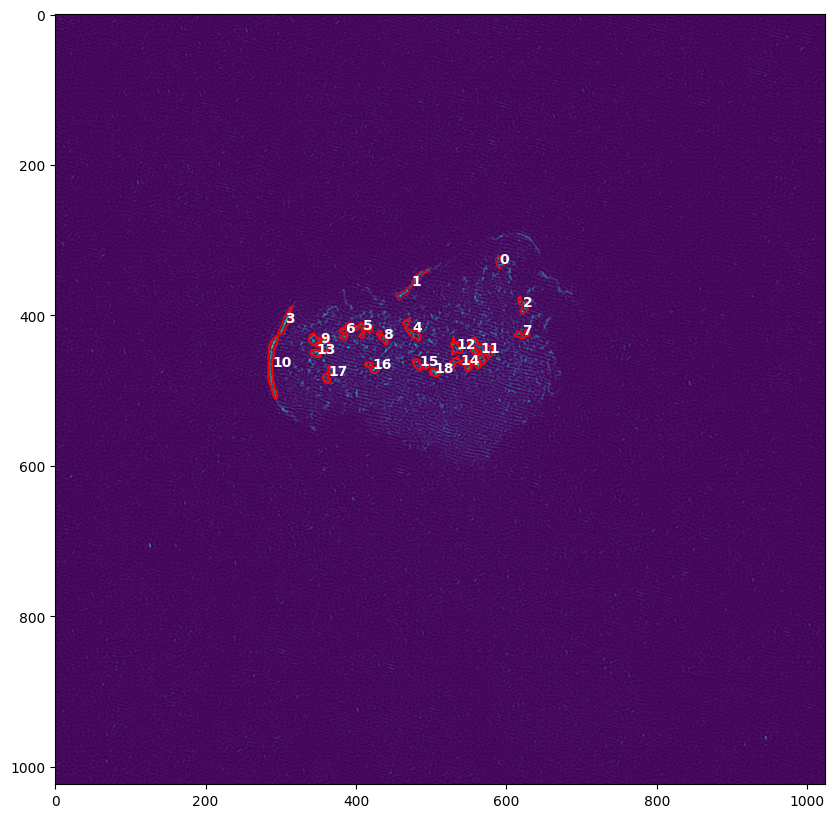

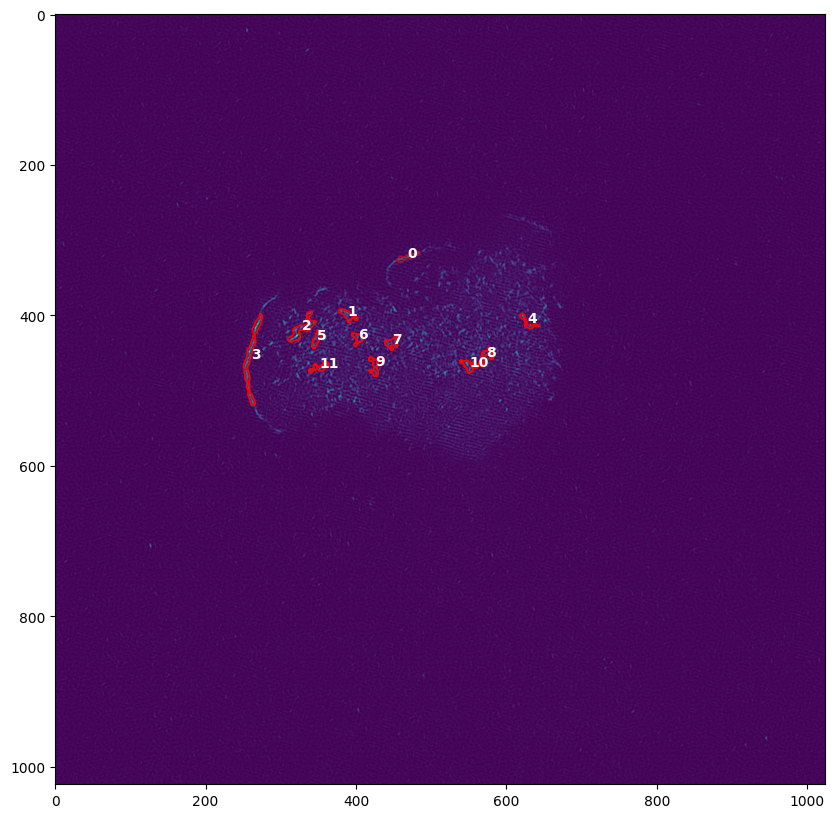

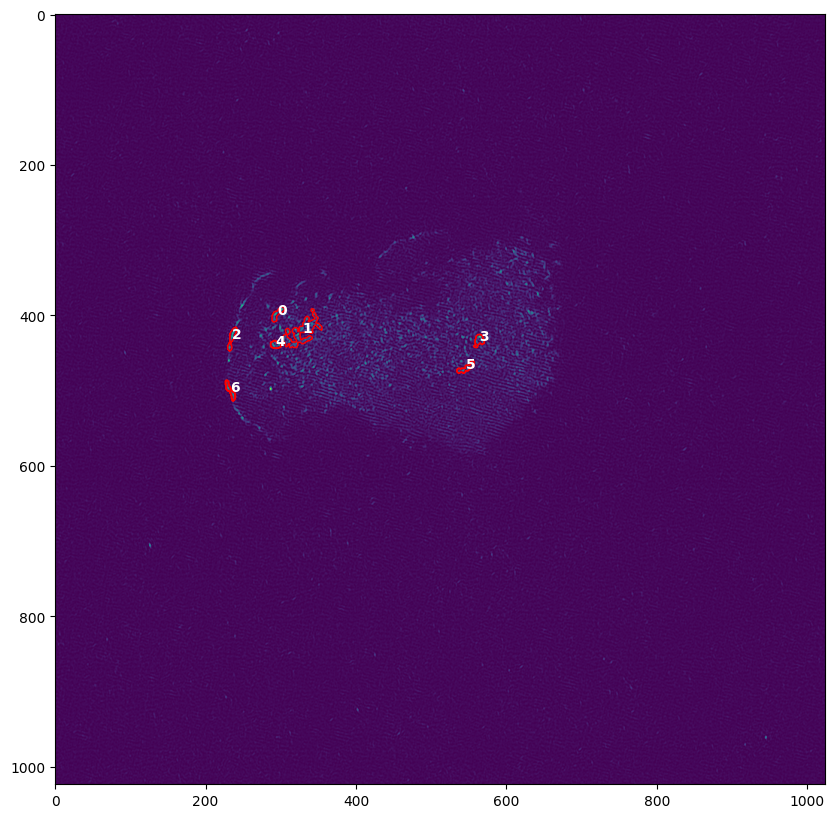

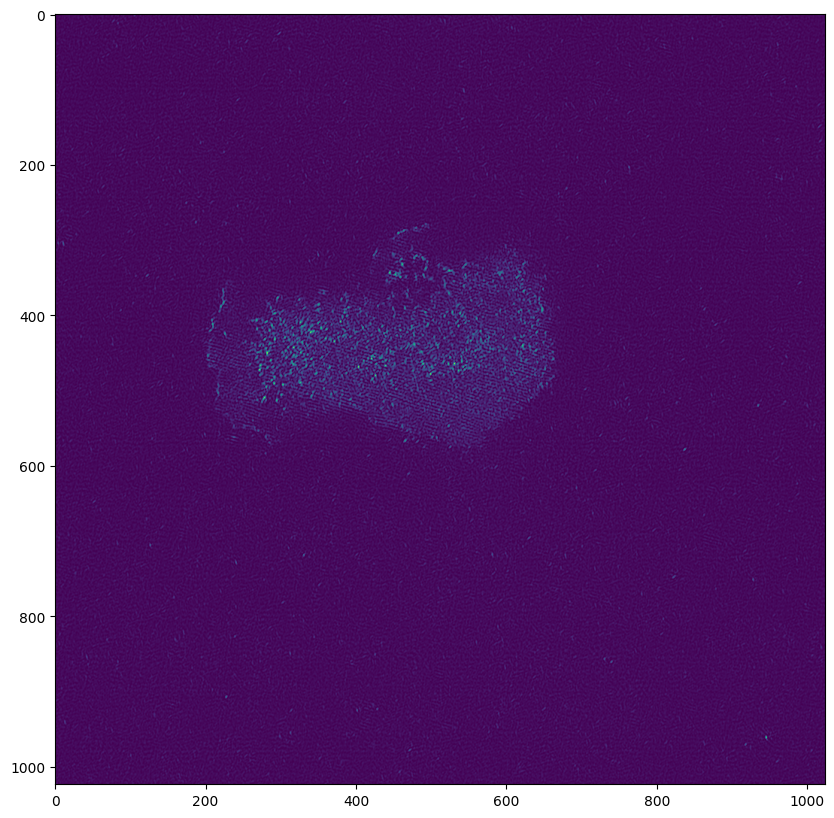

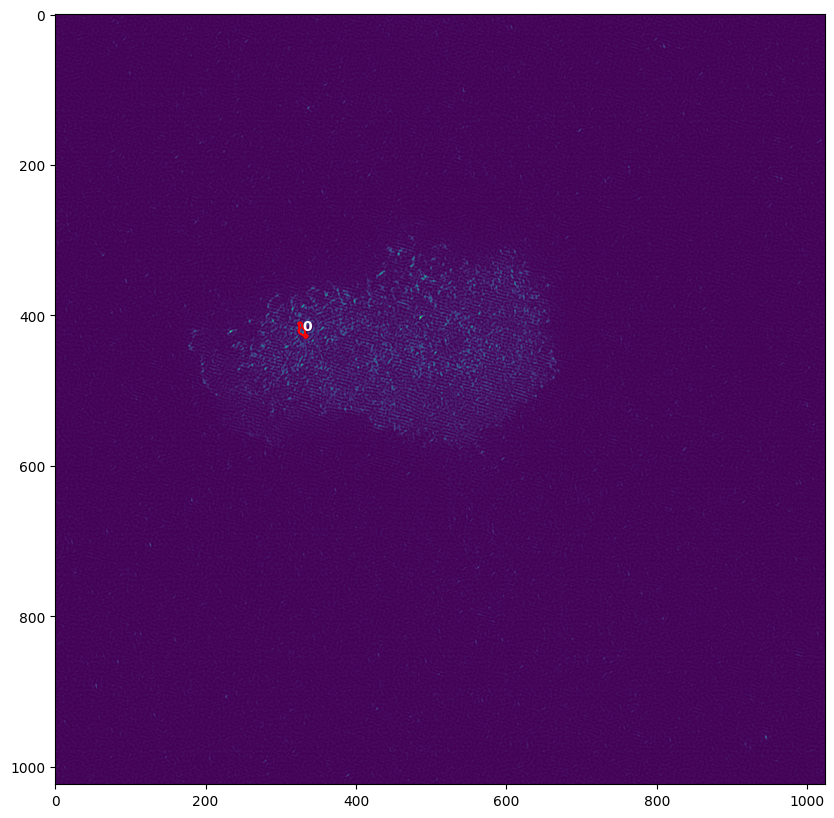

In [11]:
# Segmentation of lamellipodia for quantification
lamelli = pd.DataFrame()
p = 0
threshold = threshold_otsu(image)
sigma = 2
# manually pick out the lammelipodia
num =[[3,10],[3],[2],[],[]]
for i in range(image.shape[0]):
    prop,label_mask_clean = seg_cells(image[i],85,sigma,100,100000,True)
    for r in range(len(prop)): 
        y_center, x_center = prop[r].centroid # note that image coordinates are often given as (y, x) rather than (x, y)
        plt.text(x_center, y_center,r, fontweight = 'bold', color = 'white')

    for n in num[i]:
#         plt.imshow(image[i])
#         plt.contour(label_mask_clean,colors = 'red')
#         plt.show()
#         print(num[i])
        lamelli.at[p,'intensity'] = prop[n].intensity_image.sum()
        lamelli.at[p,'area'] = prop[n].area
        lamelli.at[p,'perimeter'] = prop[n].perimeter_crofton
        lamelli.at[p,'unit_length_intensity'] = prop[n].intensity_image.sum()/prop[n].perimeter_crofton
        lamelli.at[p,'label'] = n
        lamelli.at[p,'frame'] = i
        p += 1


In [12]:
lamelli

intensity   area   perimeter  unit_length_intensity  label  frame
0  36867.070312  225.0   87.300406             422.301248    3.0    0.0
1  74664.703125  478.0  178.218828             418.949580   10.0    0.0
2  96022.453125  611.0  263.853153             363.923842    3.0    1.0
3  23859.654297  146.0   71.441341             333.975453    2.0    2.0

In [13]:
lamelli.unit_length_intensity.mean()

384.7875306590355

In [3277]:
# result_lamelli = pd.DataFrame()

In [3278]:
result_lamelli.at[len(result_lamelli),'unit_length_intensity'] = lamelli.unit_length_intensity.mean()
result_lamelli.at[len(result_lamelli)-1,'cell'] = name

In [3206]:
result_lamelli.to_csv(PATH+'unit_length_intensity.csv')

# Quantification of Hem1-eGFP expression level

In [14]:
name = "241030_Hem1KO_Hem1-eGFP_fmlp_epi_2-7.tif"
image_epi = io.imread(PATH + 'example_images/' + name)

In [15]:
# image_epi = image_epi.T

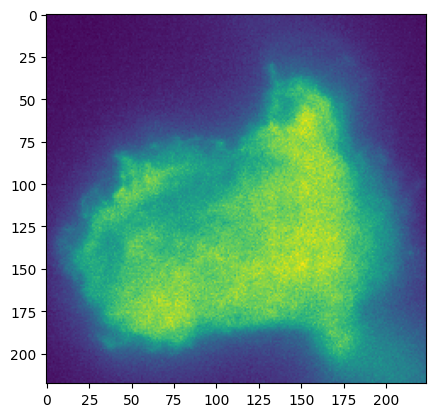

In [16]:
plt.imshow(image_epi[2])

In [17]:
thres = threshold_otsu(image_epi)-50
thres

691

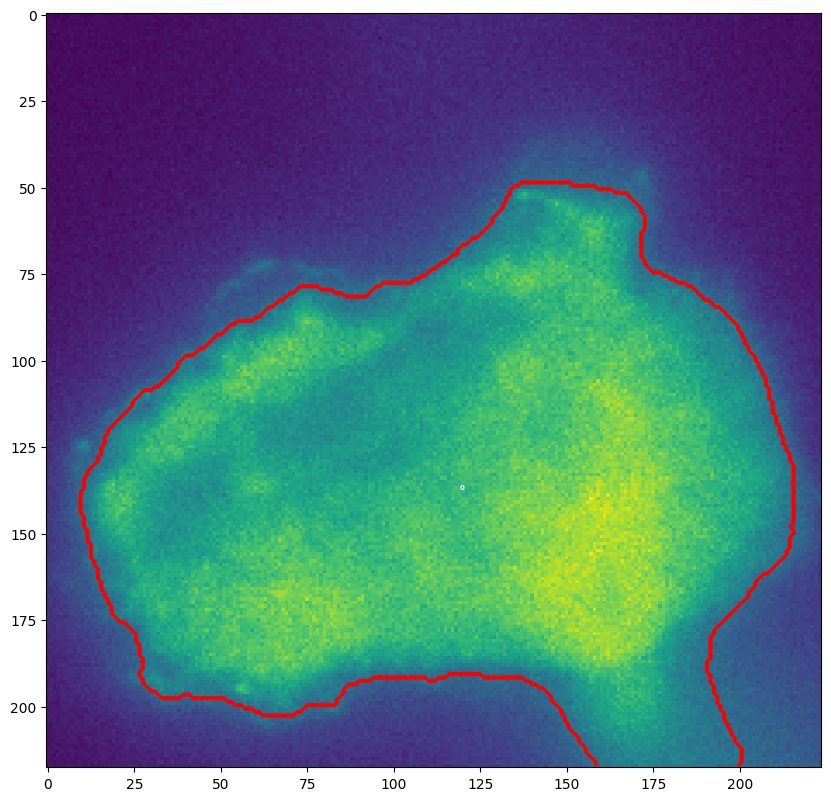

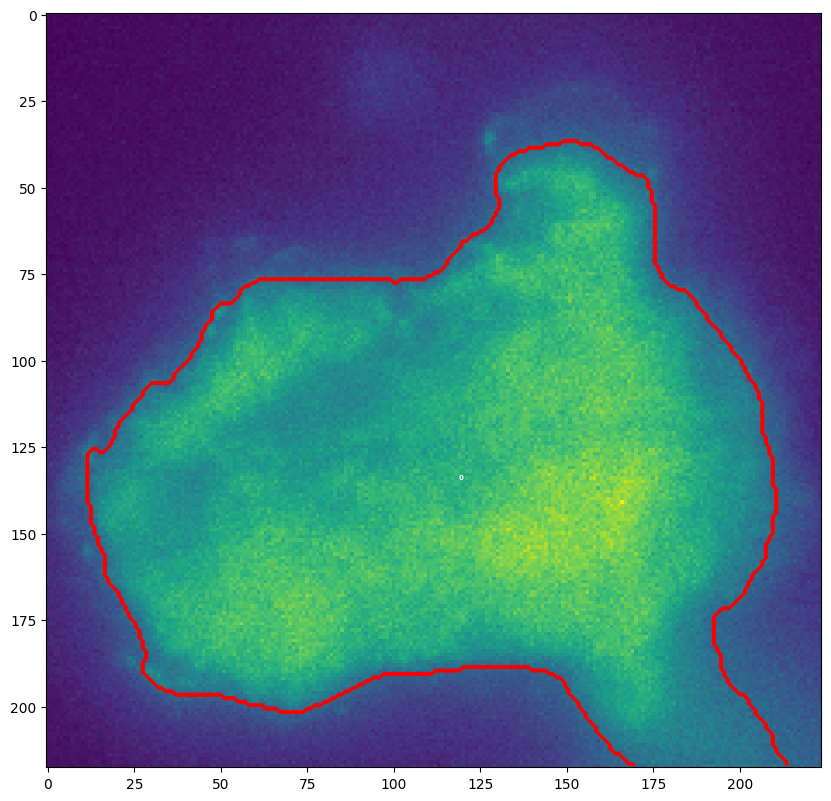

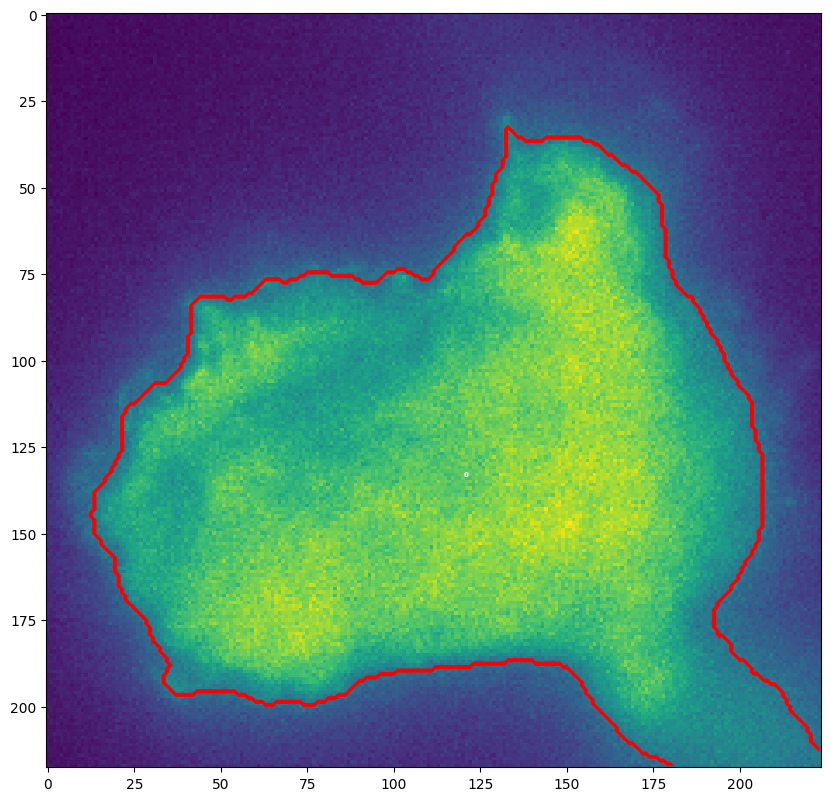

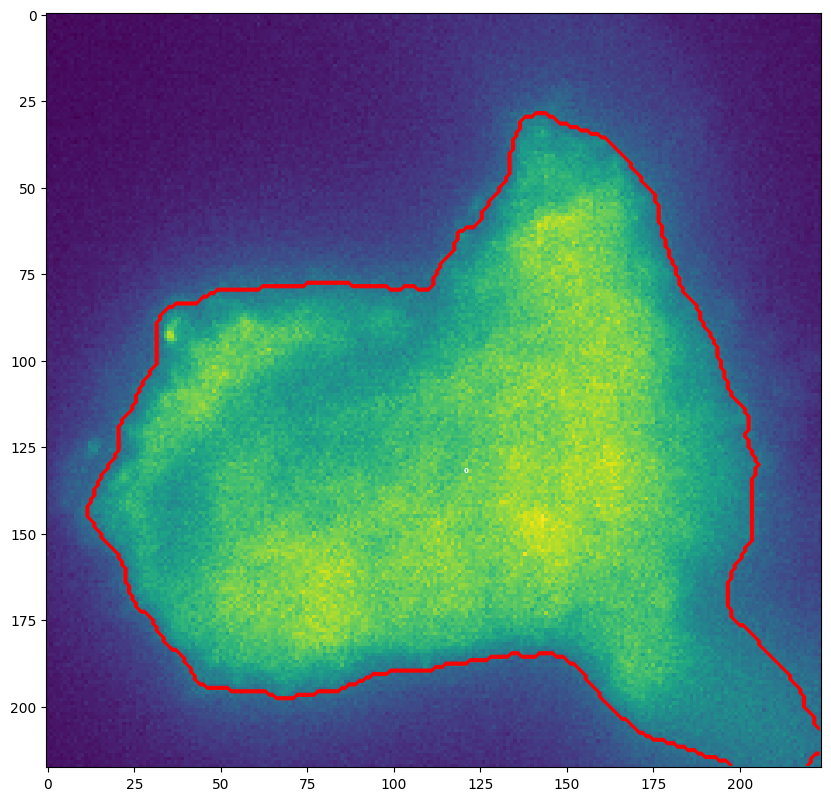

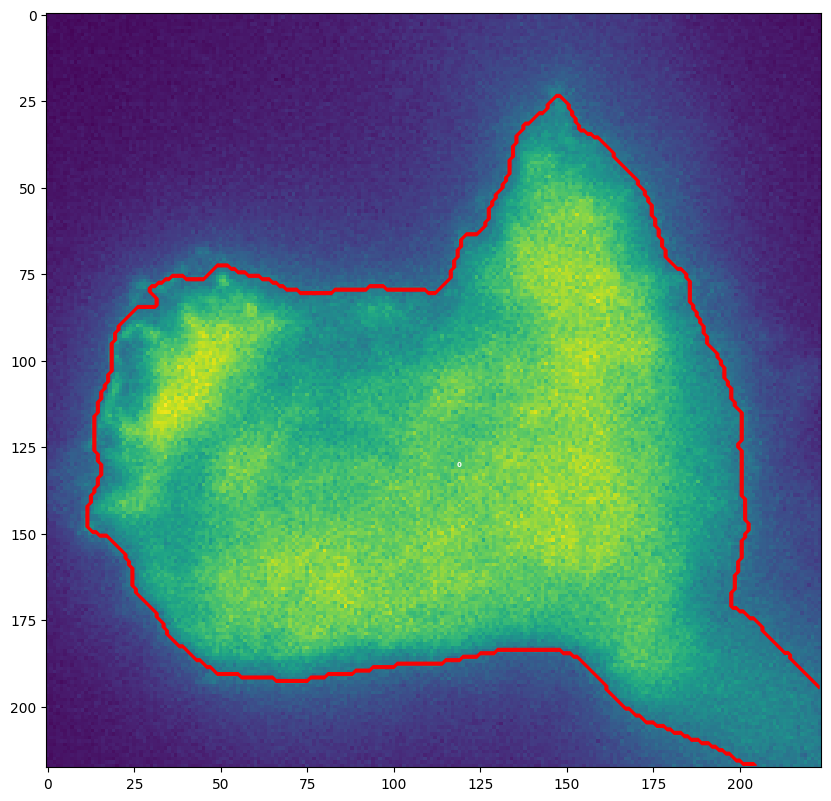

In [18]:
features = pd.DataFrame()
for i in range(len(image_epi)):
    prop,label_mask_clean = seg_cells(image_epi[i],thres,2,10000,1200000,True)
    
    for j in range(len(prop)): 
        y_center, x_center = prop[j].centroid # note that image coordinates are often given as (y, x) rather than (x, y)
        plt.text(x_center, y_center, str(j), fontweight = 'bold', color = 'white',size = 5)

        features = features.append([{'label':prop[j].label,'x': prop[j].centroid[0],
                                 'y': prop[j].centroid[1],'frame': i,
                                    'area':prop[j].area,'intensity':prop[j].intensity_mean}])
epi_intens = features.intensity.mean()

In [19]:
features

label           x           y  frame   area    intensity
0      1  137.049809  118.942261      0  23329  1083.162759
0      1  134.371883  118.862483      1  23459  1068.194808
0      1  133.376868  120.037322      2  23284  1072.190990
0      1  132.125114  120.040187      3  23067  1071.236788
0      1  130.438633  118.285064      4  23058  1060.045581

In [20]:
epi_intens

1070.9661850953646

In [21]:
# express_level_lamel = pd.DataFrame()

In [3092]:
express_level_lamel.at[len(express_level_lamel),'express_level'] = epi_intens
express_level_lamel.at[len(express_level_lamel)-1,'cell'] = name

In [3205]:
express_level_lamel.to_csv(PATH+'expression_level.csv')

### 

# Generate plots

In [13]:
result = pd.DataFrame()

In [14]:
express_level_lamel = pd.read_csv(PATH + 'csv_data/lamel_expression_level.csv')

In [15]:
result_lamelli = pd.read_csv(PATH +'csv_data/lamel_unit_length_intensity.csv')

In [16]:
result['expression level'] = express_level_lamel['express_level']
result['unit length intensity'] = result_lamelli['unit_length_intensity']
result['cell'] = result_lamelli['cell']

In [17]:
len(result)

50

In [18]:
selected_epi = ['241104_Hem1KO_Hem1-eGFP_fmlp_epi_1-14.tif','241106_Hem1KO_Hem1_eGFP_fmlp_epi_2-9.tif','241106_Hem1KO_Hem1_eGFP_fmlp_epi_1-3.tif',
            '241104_Hem1KO_Hem1-eGFP_fmlp_epi_1-3.tif','241104_Hem1KO_Hem1-eGFP_fmlp_epi_1-17.tif','241106_Hem1KO_Hem1_eGFP_fmlp_epi_1-7.tif']

In [19]:
select_exp = express_level_lamel[express_level_lamel.cell.isin(selected_epi)]

In [20]:
select_exp = select_exp.sort_values('express_level')

In [21]:
select_exp

express_level                                       cell
17     410.880457  241104_Hem1KO_Hem1-eGFP_fmlp_epi_1-14.tif
38     659.162178   241106_Hem1KO_Hem1_eGFP_fmlp_epi_2-9.tif
32     832.031616   241106_Hem1KO_Hem1_eGFP_fmlp_epi_1-3.tif
12    1050.794855   241104_Hem1KO_Hem1-eGFP_fmlp_epi_1-3.tif
18    1169.113862  241104_Hem1KO_Hem1-eGFP_fmlp_epi_1-17.tif
35    1563.274335   241106_Hem1KO_Hem1_eGFP_fmlp_epi_1-7.tif

In [22]:
selected_lamelli = ['241104_Hem1KO_Hem1-eGFP_fmlp_tirf_1-14_SIR.tif','241106_Hem1KO_Hem1_eGFP_fmlp_tirf_2-9_SIR.tif','241106_Hem1KO_Hem1_eGFP_fmlp_tirf_1-3_SIR.tif',
            '241104_Hem1KO_Hem1-eGFP_fmlp_tirf_1-3_SIR.tif','241104_Hem1KO_Hem1-eGFP_fmlp_tirf_1-17_SIR.tif','241106_Hem1KO_Hem1_eGFP_fmlp_tirf_1-7_SIR.tif']

In [23]:
select_lamelli = result_lamelli[result_lamelli.cell.isin(selected_lamelli)]

In [24]:
select_lamelli = select_lamelli.reindex(index=[17,38,32,12,18,35])

In [25]:
select_lamelli

unit_length_intensity                                            cell
17             413.639911  241104_Hem1KO_Hem1-eGFP_fmlp_tirf_1-14_SIR.tif
38             417.046443   241106_Hem1KO_Hem1_eGFP_fmlp_tirf_2-9_SIR.tif
32             401.867043   241106_Hem1KO_Hem1_eGFP_fmlp_tirf_1-3_SIR.tif
12             415.931428   241104_Hem1KO_Hem1-eGFP_fmlp_tirf_1-3_SIR.tif
18             399.092566  241104_Hem1KO_Hem1-eGFP_fmlp_tirf_1-17_SIR.tif
35             421.057413   241106_Hem1KO_Hem1_eGFP_fmlp_tirf_1-7_SIR.tif

In [26]:
cmap = plt.cm.get_cmap('Greens')
palette = cmap(np.linspace(0.3, 0.8, 6))

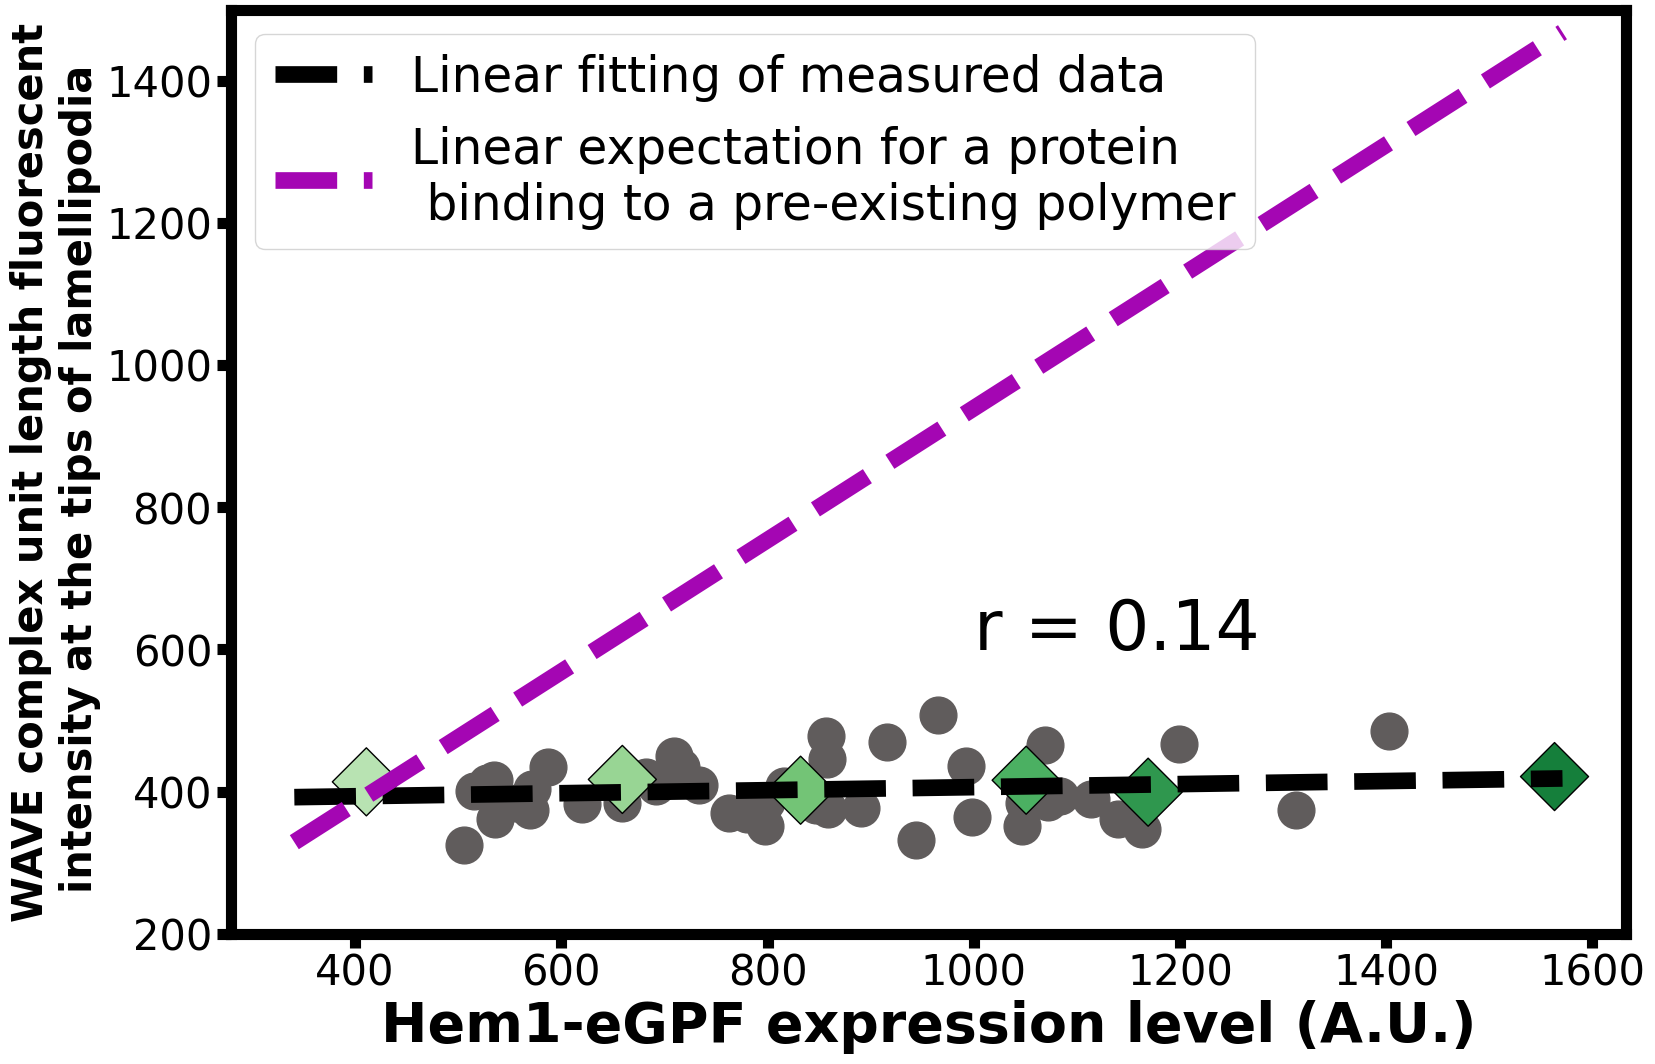

In [27]:
fig,ax  = plt.subplots(figsize = (18,12))
plt.scatter(result['expression level'],result['unit length intensity'],s = 700,marker = 'o',color = '#605c5c')
plt.ylim(200,1500)
popt = curve_fit(f_linear,result['expression level'],result['unit length intensity'])[0]
plt.xlabel('Hem1-eGPF expression level (A.U.)',size = 40,fontweight = 'bold')
plt.ylabel('WAVE complex unit length fluorescent\nintensity at the tips of lamellipodia ',size = 30,fontweight= 'bold')
xn = np.arange(341,1500,30)
xn = np.arange(341,1600,30)
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(8)
# increase tick width
ax.tick_params(width=8,size = 10)

plt.yticks(size = 30)
plt.xticks(size = 30)
plt.plot(xn,f_linear(xn,popt[0],popt[1]),linestyle = '--',color = 'black',label = 'Linear fitting of measured data',lw = 12)
plt.plot(xn,f_linear(xn,0.9265,12.78),color = '#a406b3',ls = 'dashed',label = 'Linear expectation for a protein\n binding to a pre-existing polymer',lw = 12)
plt.legend(fontsize = 35,loc = 'upper left')
plt.scatter(select_exp['express_level'],select_lamelli['unit_length_intensity'],s = 1200,marker = 'D',color = palette,edgecolor = 'black')
plt.text(1000,600,'r = 0.14',size = 50)
plt.savefig(PATH+ 'result_figures/Fig2C_lamel_correlation.png',dpi = 300,bbox_inches = 'tight')

In [28]:
stats.pearsonr(result['expression level'],result['unit length intensity'])

PearsonRResult(statistic=0.1374351439640835, pvalue=0.34121879514044723)